In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기
- train, test 데이터 불러오기

In [3]:
# path setting
data_dir = 'data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')
train_data_path

'data/train.csv'

In [4]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### 데이터 분석
  
**Data 종류**
> [설명](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/data)  
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

#### Train Data로 데이터 전처리 실습

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

#### 결측치 확인

In [8]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

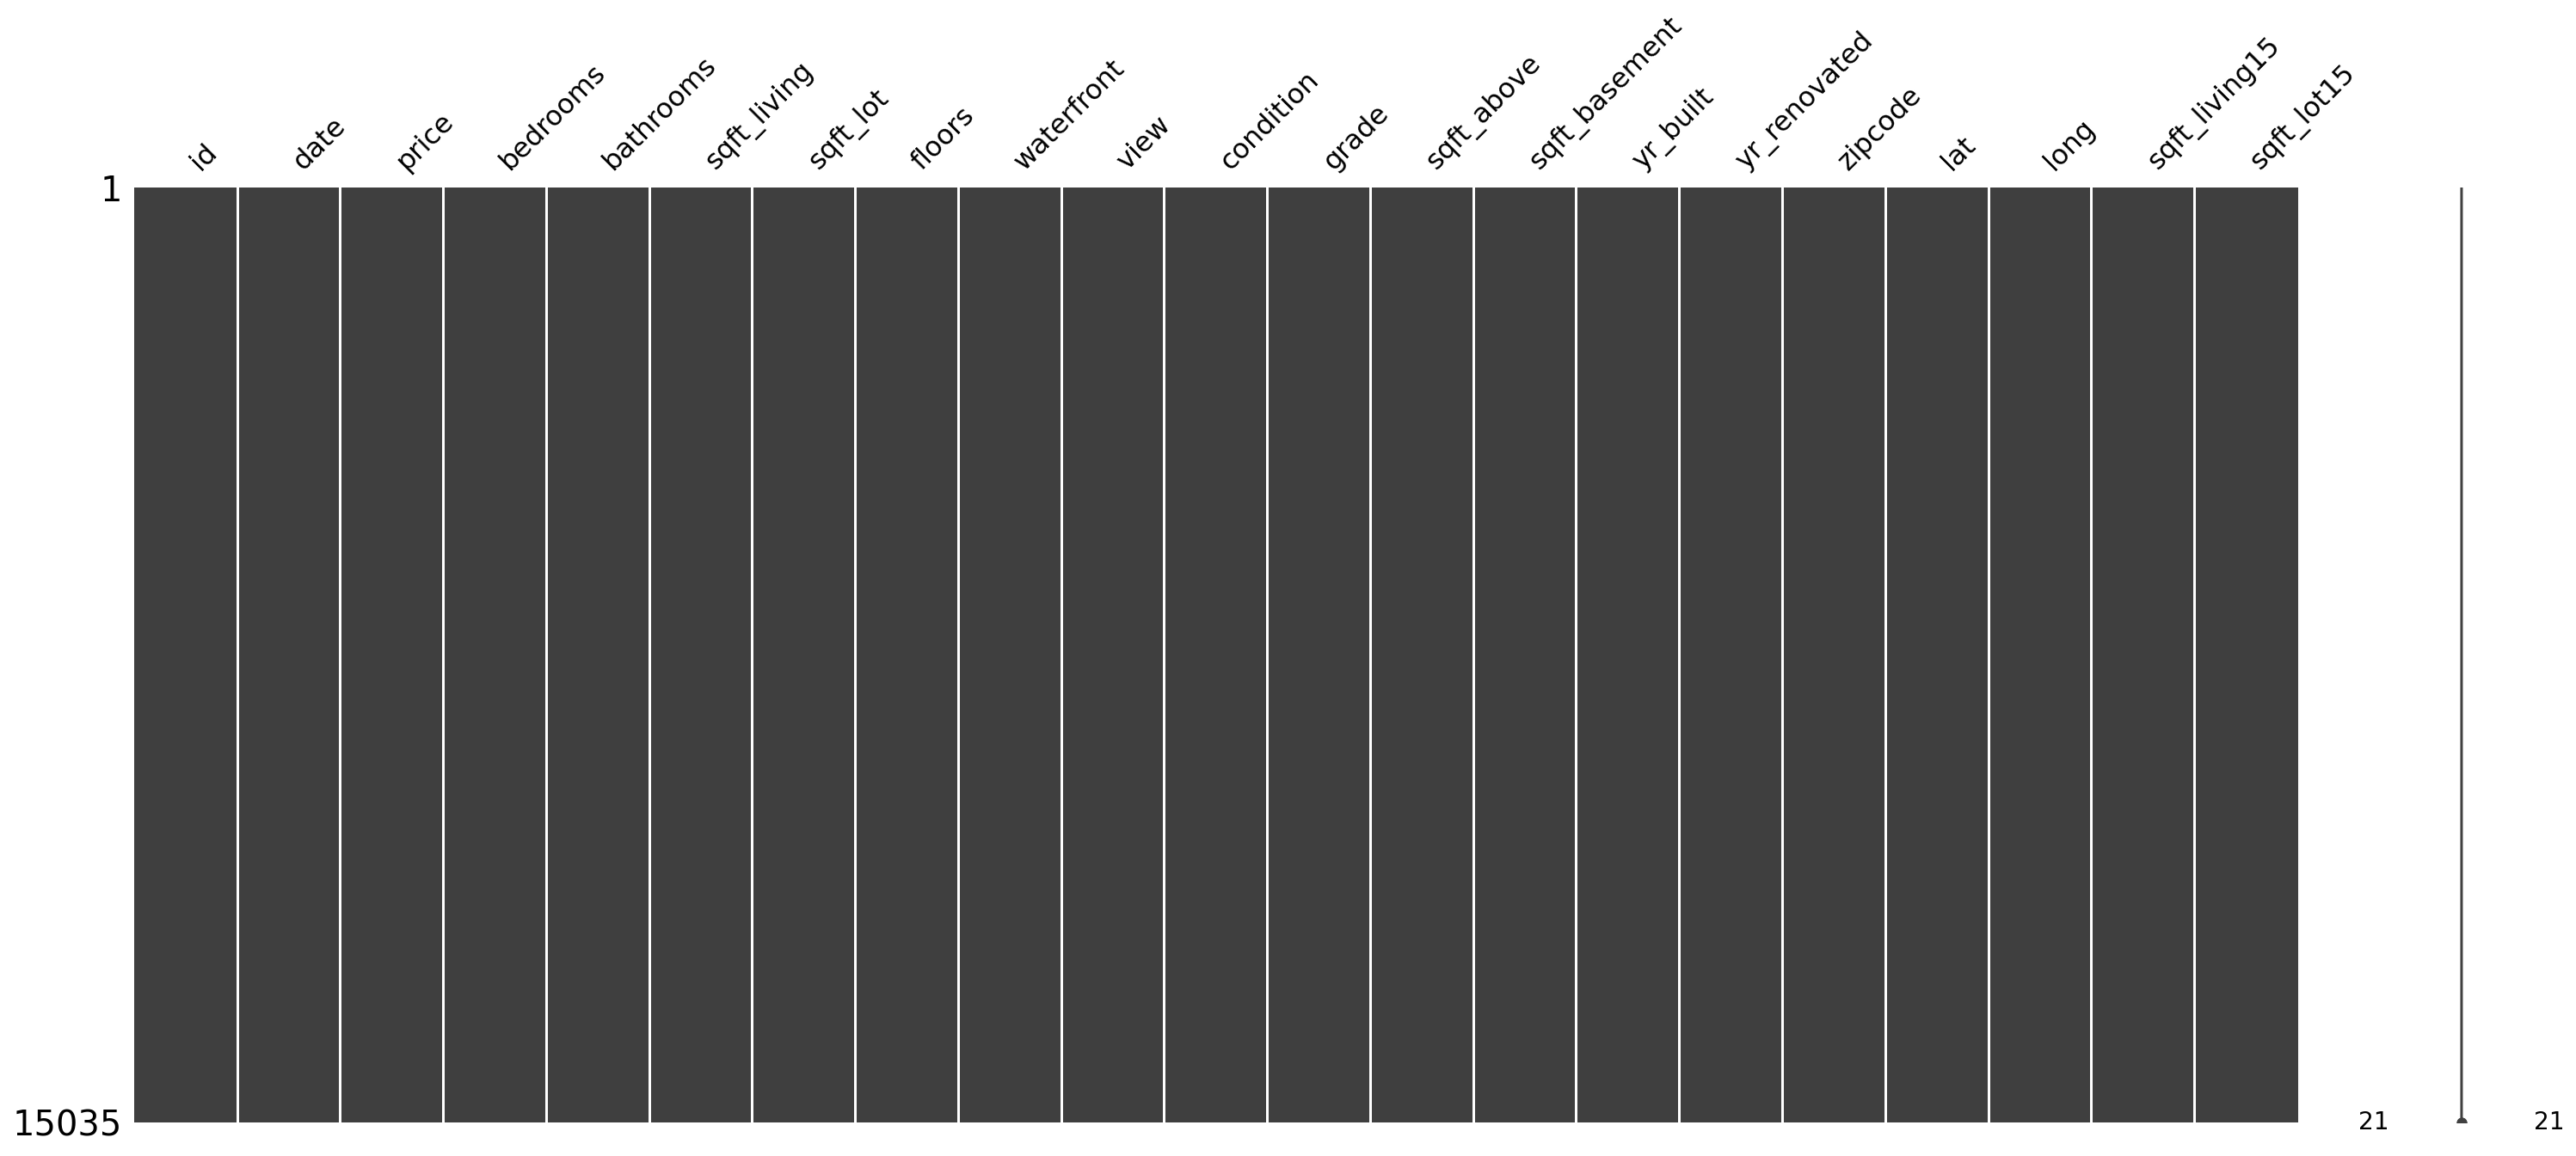

In [9]:
msno.matrix(train)

<AxesSubplot:>

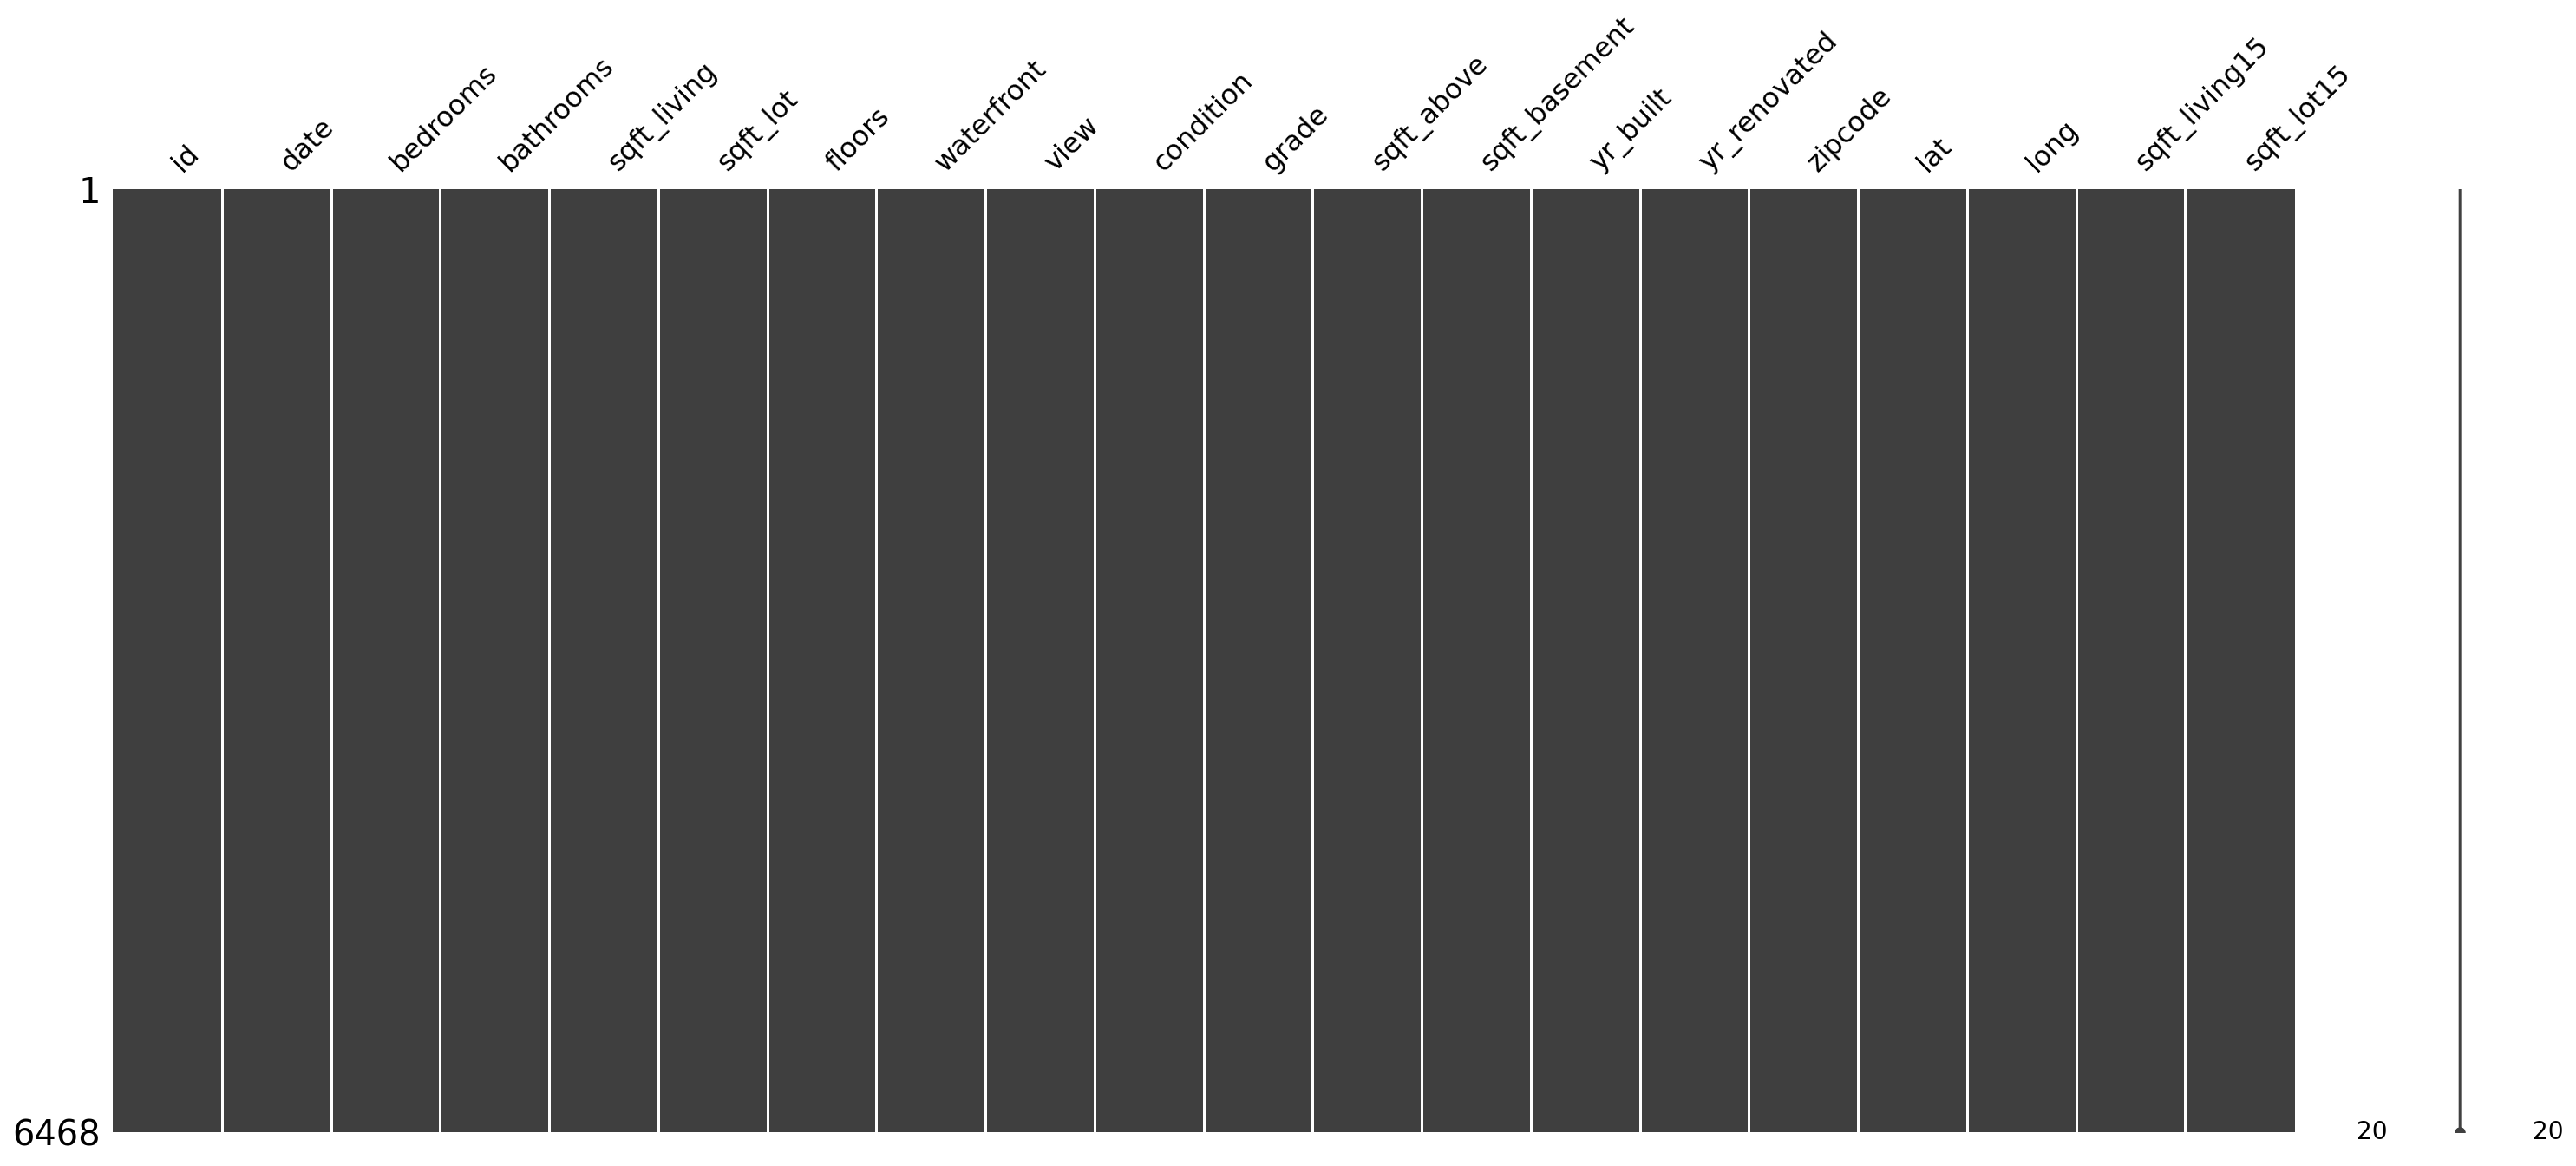

In [10]:
msno.matrix(test)

#### 날짜 분할 (year, month, day)

In [11]:
# date -> year, month, day
train['year'] = train['date'].apply(lambda x: x[0:4]).astype(int)
train['month'] = train['date'].apply(lambda x: x[4:6]).astype(int)
train['day'] = train['date'].apply(lambda x: x[6:8]).astype(int)

# one-hot encoding
train = pd.get_dummies(train, columns=['year'])
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,year_2014,year_2015
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,10,13,1,0
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062,2,25,0,1
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,2,18,0,1
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,0,98003,47.3097,-122.327,2238,6819,6,27,1,0
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,0,98198,47.4095,-122.315,1650,9711,1,15,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,0,98056,47.5137,-122.167,2520,6023,10,14,1,0
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,0,98136,47.5537,-122.398,2050,6200,3,26,0,1
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,0,98103,47.6993,-122.346,1530,1509,5,21,1,0
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,0,98146,47.5107,-122.362,1830,7200,2,23,0,1


In [12]:
train.sort_values('date')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,year_2014,year_2015
2648,2648,20140502T000000,463000.0,3,1.75,1710,7320,1.0,0,0,...,0,98155,47.7512,-122.281,2260,8839,5,2,1,0
4734,4734,20140502T000000,750000.0,3,1.75,2240,10578,2.0,0,0,...,0,98115,47.6954,-122.292,1570,10578,5,2,1,0
754,754,20140502T000000,550000.0,4,2.50,1940,10500,1.0,0,0,...,0,98052,47.6830,-122.114,2200,10500,5,2,1,0
7160,7160,20140502T000000,382500.0,4,1.75,1560,8700,1.0,0,0,...,0,98034,47.7274,-122.181,2080,8000,5,2,1,0
4002,4002,20140502T000000,419000.0,3,1.50,1570,6700,1.0,0,0,...,0,98007,47.6022,-122.134,1570,7300,5,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13479,13479,20150514T000000,725000.0,4,1.75,1980,5850,1.0,0,1,...,0,98116,47.5607,-122.391,1810,5850,5,14,0,1
8813,8813,20150514T000000,335000.0,3,2.00,1410,44866,1.0,0,0,...,0,98023,47.3273,-122.370,2950,29152,5,14,0,1
5088,5088,20150514T000000,456500.0,4,2.50,2580,11780,2.0,0,0,...,0,98038,47.3658,-122.040,2410,8403,5,14,0,1
14913,14913,20150514T000000,749950.0,4,3.50,2630,3757,2.0,0,0,...,0,98027,47.5322,-122.075,2620,2699,5,14,0,1


#### 데이터 분포 확인

In [13]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'day',
       'year_2014', 'year_2015'],
      dtype='object')

In [14]:
columns = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']

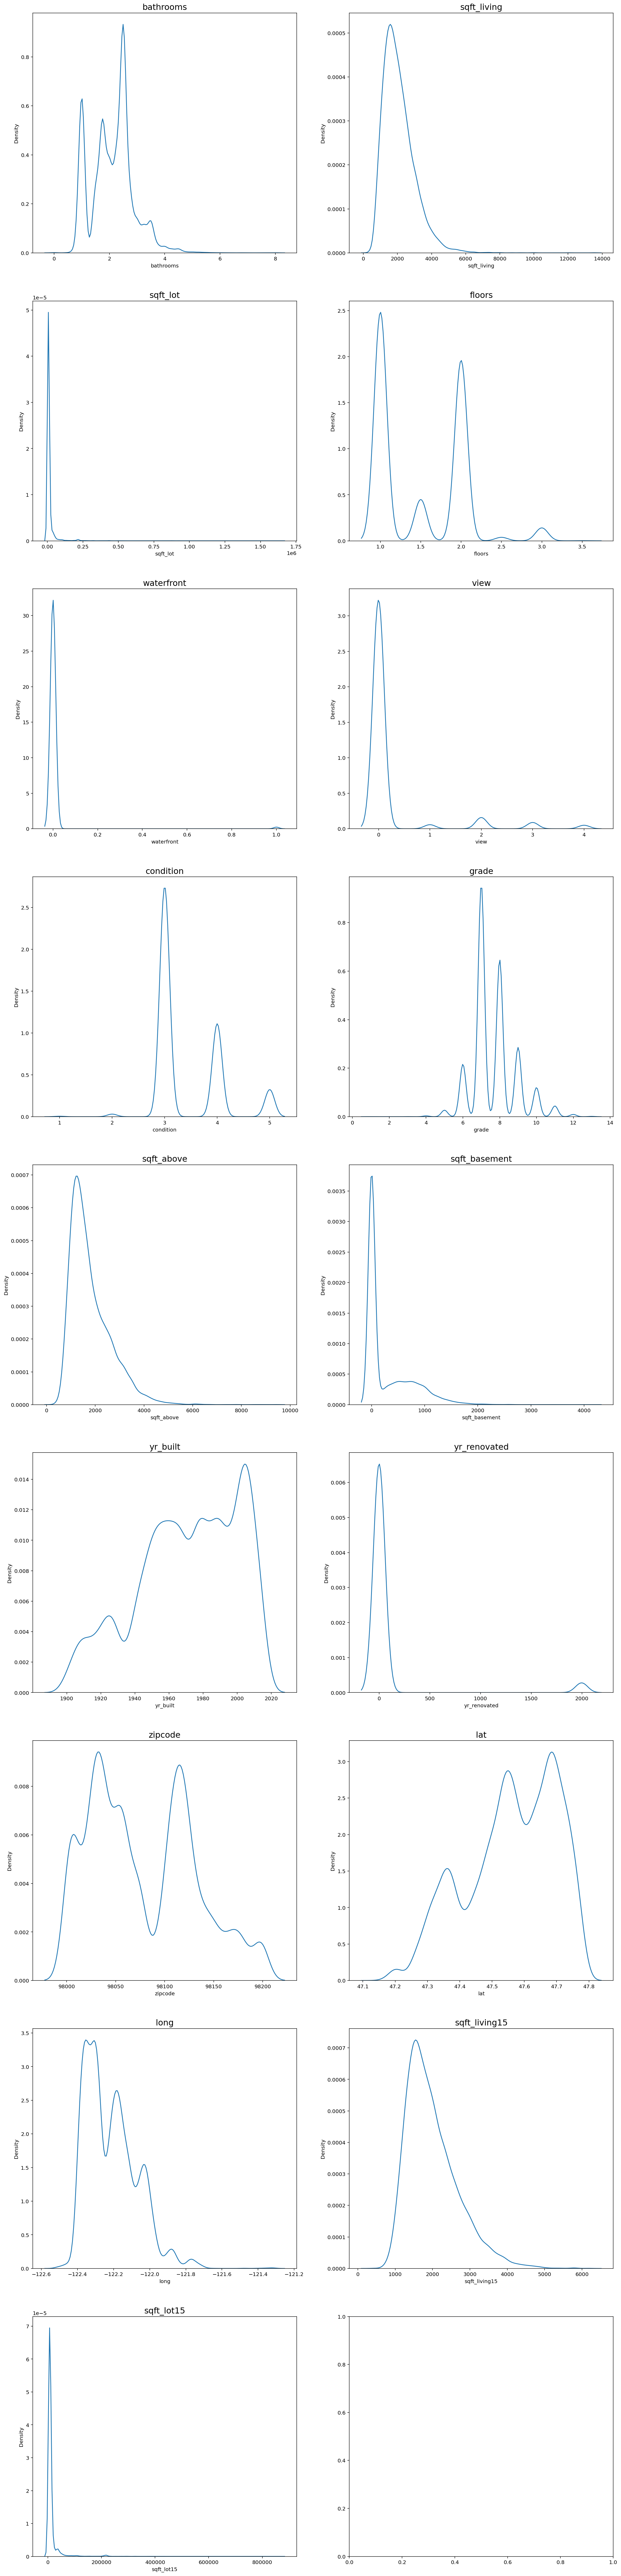

In [15]:
rows = 9
cols = 2
i = 1
fig, ax = plt.subplots(rows, cols, figsize=(20, 90))

for row in range(rows):
    for col in range(cols):
        sns.kdeplot(data=train[columns[i]], ax=ax[row][col])
        ax[row][col].set_title(columns[i], fontsize=16)
        i += 1
        
        if i >= len(columns): break

In [16]:
# log 변환을 통한 전처리
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

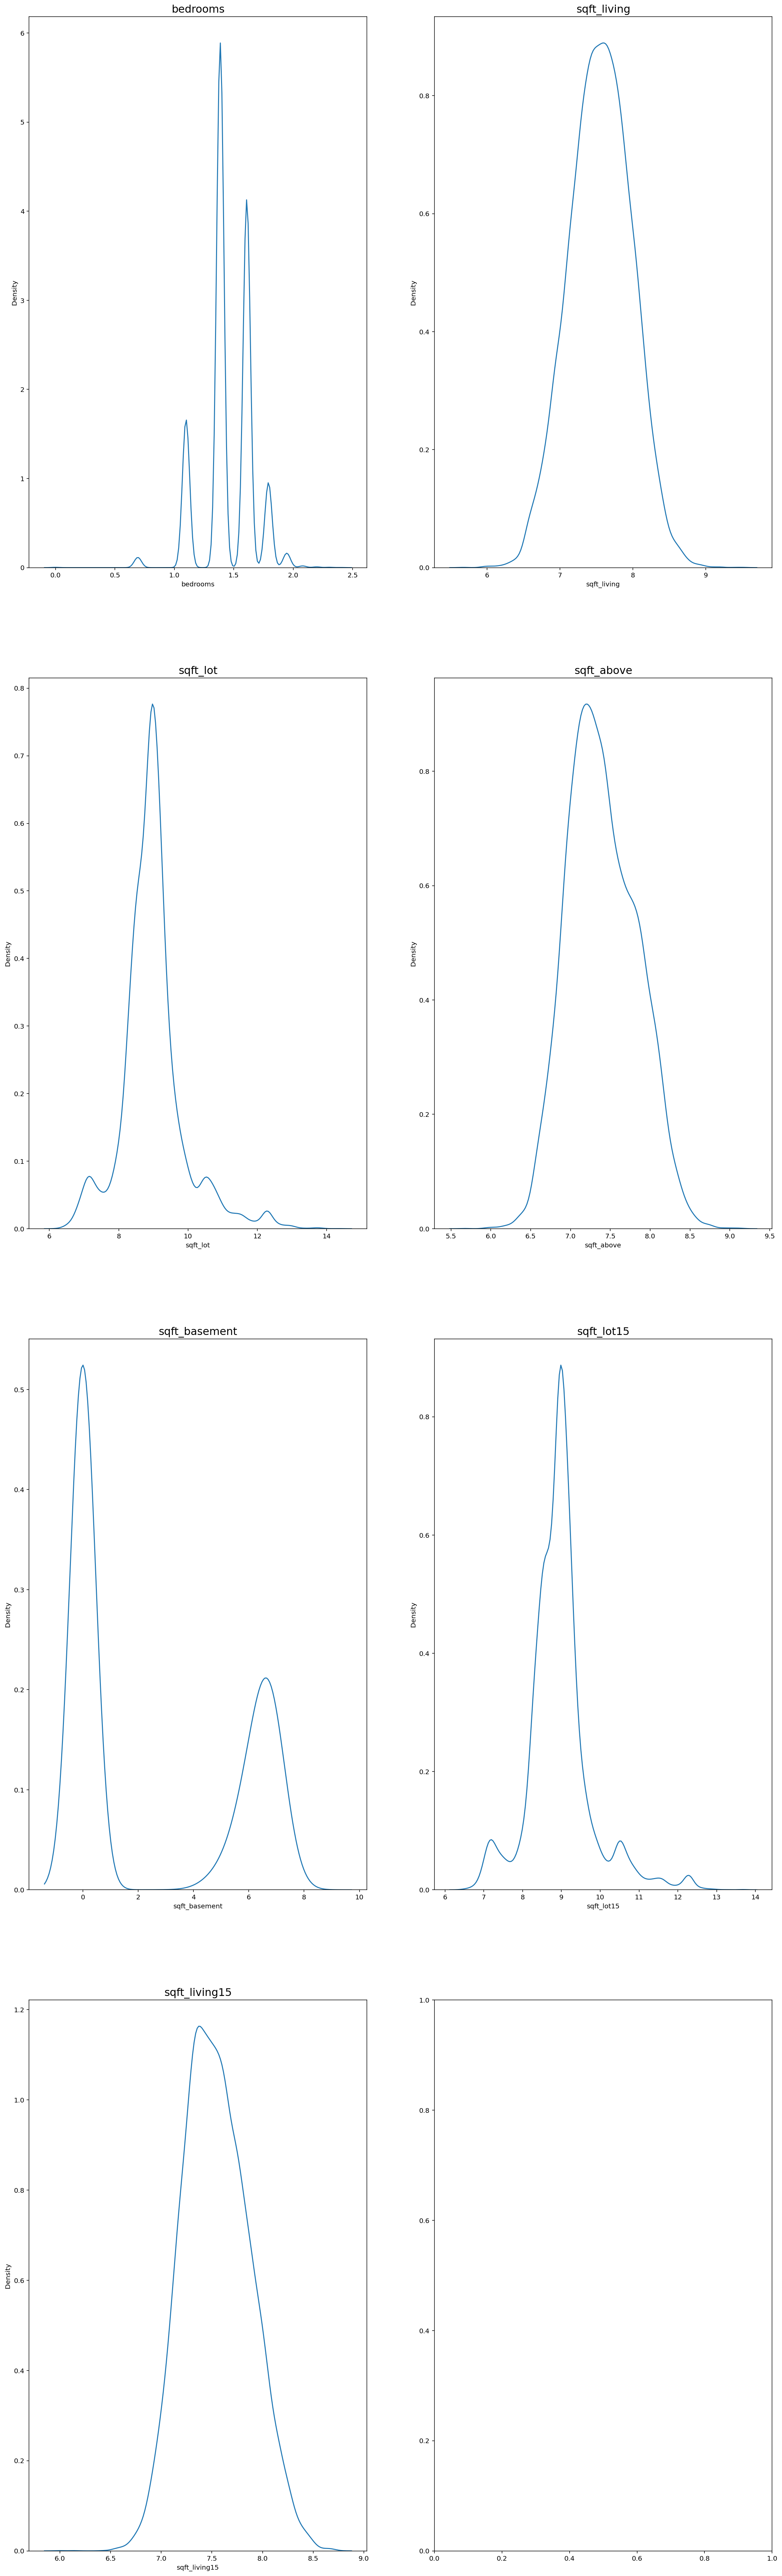

In [17]:
rows = 4
cols = 2
i = 1
fig, ax = plt.subplots(rows, cols, figsize=(20, 70))

for row in range(rows):
    for col in range(cols):
        sns.kdeplot(data=train[skew_columns[i-1]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[i-1], fontsize=16)
        i += 1
        
        if i >= len(skew_columns): break

<AxesSubplot:xlabel='price', ylabel='Density'>

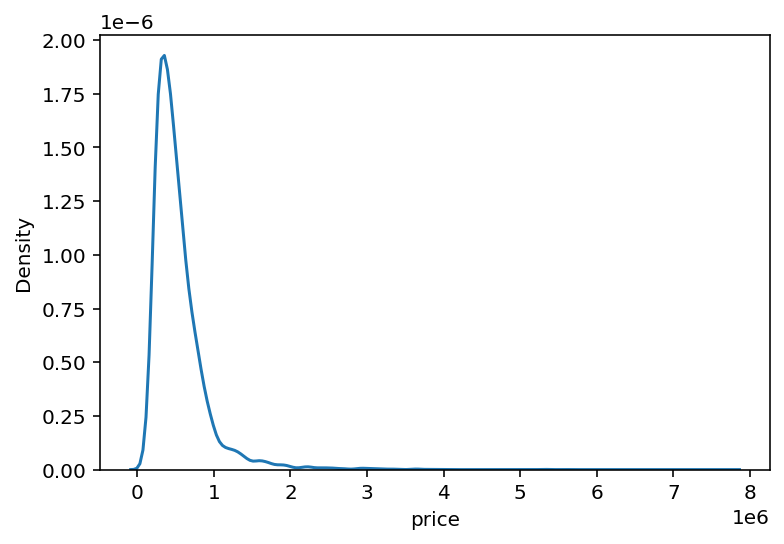

In [18]:
# 라벨(price)의 분포
sns.kdeplot(data=train, x='price')

In [19]:
# price log 변환
train['price'] = np.log1p(train['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

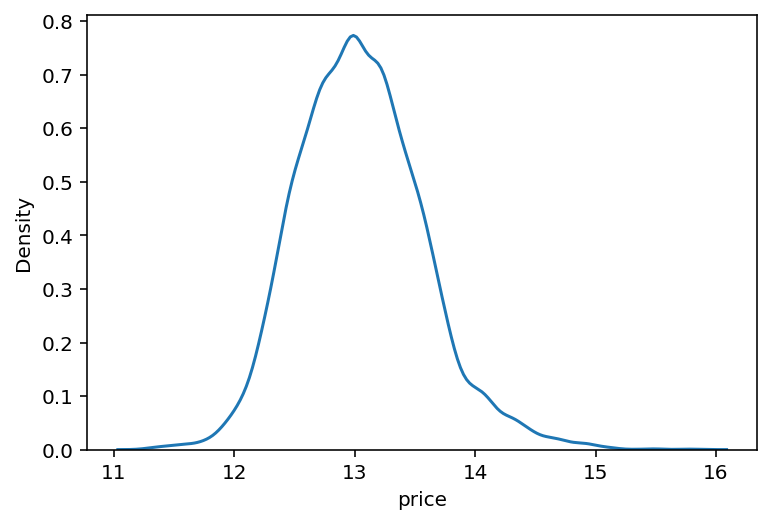

In [20]:
sns.kdeplot(data=train, x='price')

In [21]:
# 현재까지 바뀐 데이터
# date -> year, month, day 추가
# bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15, sqft_living15, price -> log 변환
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,year_2014,year_2015
0,0,20141013T000000,12.309987,1.386294,1.00,7.074117,8.639588,1.0,0,0,...,0,98178,47.5112,-122.257,7.201171,8.639588,10,13,1,0
1,1,20150225T000000,12.100718,1.098612,1.00,6.647688,9.210440,1.0,0,0,...,0,98028,47.7379,-122.233,7.908755,8.995041,2,25,0,1
2,2,20150218T000000,13.142168,1.386294,2.00,7.427144,8.997271,1.0,0,0,...,0,98074,47.6168,-122.045,7.496097,8.923191,2,18,0,1
3,3,20140627T000000,12.458779,1.386294,2.25,7.447751,8.827615,2.0,0,0,...,0,98003,47.3097,-122.327,7.713785,8.827615,6,27,1,0
4,4,20150115T000000,12.583999,1.386294,1.50,6.966967,9.181118,1.0,0,0,...,0,98198,47.4095,-122.315,7.409136,9.181118,1,15,0,1


### Train 데이터 선택

In [22]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'day',
       'year_2014', 'year_2015'],
      dtype='object')

<Axes:>

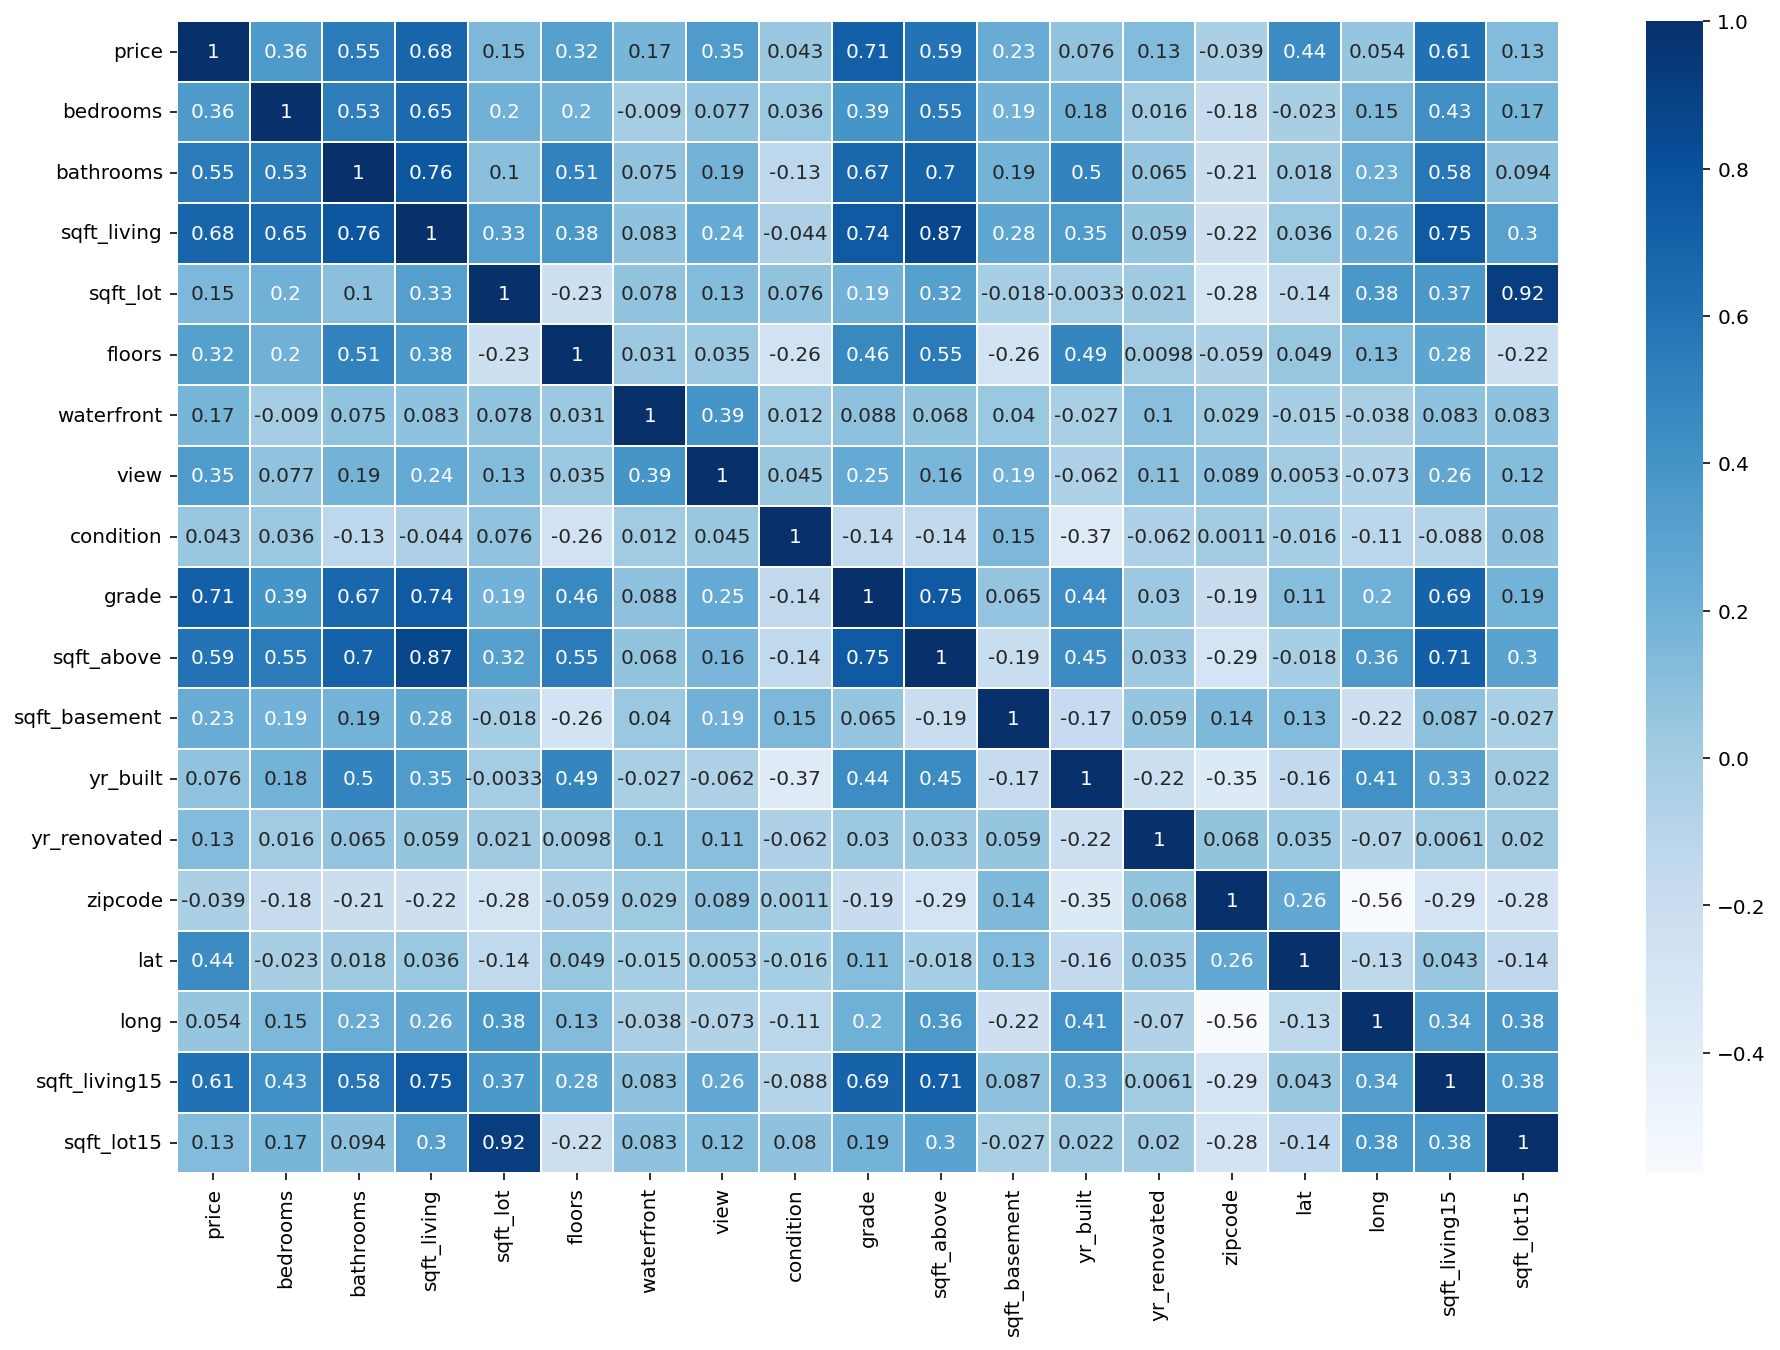

In [23]:
corr_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'
]
corr = train[corr_cols].corr()
sns.heatmap(
    corr, linewidths=0.1, annot=True,cmap='Blues',linecolor="white", ax=plt.axes([0,0,2,2])
)

In [24]:
# price 상관관계 중 0.4 이상만 따로 분리
corr_cols = ['bathrooms','sqft_living','grade','sqft_above', 'lat','sqft_living15']

In [25]:
# 라벨값 구분
y = train['price']
train = train.drop(['price'], axis=1)

In [26]:
# id, date 제외
print(train.columns)
train = train.drop(['id','date'], axis=1)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'day', 'year_2014',
       'year_2015'],
      dtype='object')


In [27]:
print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'day', 'year_2014',
       'year_2015'],
      dtype='object')


### Test 데이터 전처리
> Train에서 전처리한 내용 그대로 사용
1. date -> year, month, day 추가
2. bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15, sqft_living15 -> log 변환
3. id, date 삭제

date -> year, month, day 추가

In [28]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [29]:
test['year'] = test['date'].apply(lambda x: x[0:4]).astype(int)
test['month'] = test['date'].apply(lambda x: x[4:6]).astype(int)
test['day'] = test['date'].apply(lambda x: x[6:8]).astype(int)

test = pd.get_dummies(test, columns=['year'])
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,year_2014,year_2015
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,...,1991,98125,47.7210,-122.319,1690,7639,12,9,1,0
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,...,0,98136,47.5208,-122.393,1360,5000,12,9,1,0
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,...,0,98053,47.6561,-122.005,4760,101930,5,12,1,0
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,...,0,98146,47.5123,-122.337,1780,8113,4,15,0,1
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,...,0,98038,47.3684,-122.031,2390,7570,3,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,...,0,98010,47.3095,-122.002,1320,11303,6,26,1,0
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,...,0,98144,47.5699,-122.288,1400,1230,1,26,0,1
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,...,0,98116,47.5773,-122.409,1330,1265,2,19,0,1
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,...,0,98144,47.5944,-122.299,1020,2007,6,23,1,0


In [30]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'day', 'year_2014',
       'year_2015'],
      dtype='object')

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15, sqft_living15 -> log 변환

In [31]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
test[skew_columns]

,bedrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_lot15,sqft_living15
0,3,2570,7242,2170,400,7639,1690
1,4,1960,5000,1050,910,5000,1360
2,4,5420,101930,3890,1530,101930,4760
3,3,1780,7470,1050,730,8113,1780
4,3,1890,6560,1890,0,7570,2390
...,...,...,...,...,...,...,...
6463,3,1500,11968,1500,0,11303,1320
6464,3,1490,1126,1490,0,1230,1400
6465,3,1310,1294,1180,130,1265,1330
6466,2,1020,1350,1020,0,2007,1020


In [32]:
for c in skew_columns:
    test[c] = np.log1p(test[c].values)
test[skew_columns]

,bedrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_lot15,sqft_living15
0,1.386294,7.852050,8.887791,7.682943,5.993961,8.941153,7.433075
1,1.609438,7.581210,8.517393,6.957497,6.814543,8.517393,7.215975
2,1.609438,8.598036,11.532051,8.266421,7.333676,11.532051,8.468213
3,1.386294,7.484930,8.918784,6.957497,6.594413,9.001346,7.484930
4,1.386294,7.544861,8.788898,7.544861,0.000000,8.932080,7.779467
...,...,...,...,...,...,...,...
6463,1.386294,7.313887,9.390075,7.313887,0.000000,9.332912,7.186144
6464,1.386294,7.307202,7.027315,7.307202,0.000000,7.115582,7.244942
6465,1.386294,7.178545,7.166266,7.074117,4.875197,7.143618,7.193686
6466,1.098612,6.928538,7.208600,6.928538,0.000000,7.604894,6.928538


id, date 삭제

In [33]:
test = test.drop(['id','date'], axis=1)
test.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'day', 'year_2014',
       'year_2015'],
      dtype='object')

In [34]:
list(train.columns) == list(test.columns)

True

### 학습 시도

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# log로 치환한 price 값을 다시 원 형태로 변환
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [36]:
# train, test 분할
random_state = 2000

X_train, X_test, y_train, y_test = train_test_split(
    train, y, test_size=0.2, random_state=random_state
)

In [37]:
# xgboost, lightgbm 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

In [38]:
# model별 rmse 측정
def get_scores(models, X_train, y_train, X_test, y_test):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
    return df

In [39]:
models = [xgboost, lightgbm]
get_scores(models, X_train, y_train, X_test, y_test)

{'XGBRegressor': 148585.85336648213, 'LGBMRegressor': 134408.95208988542}

#### GridSearchCV를 이용한 lightgbm 최적의 파라미터 찾기

In [40]:
# GridSearchCV를 이용한 lightgbm 최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10],
    'learning_rate': [0.05, 0.08, 0.1]
}

lightgbm = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(
    lightgbm, param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5, verbose=1, n_jobs=5
)

grid_model.fit(train, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2000), n_jobs=5,
             param_grid={'learning_rate': [0.05, 0.08, 0.1],
                         'max_depth': [8, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [41]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score
results['RMSLE'] = np.sqrt(-1* results['score'])
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,n_estimators,score,RMSLE
11,0.08,10,300,-0.026157,0.161730
8,0.08,8,300,-0.026207,0.161885
17,0.10,10,300,-0.026240,0.161986
16,0.10,10,200,-0.026320,0.162236
5,0.05,10,300,-0.026330,0.162264
10,0.08,10,200,-0.026367,0.162378
14,0.10,8,300,-0.026392,0.162457
2,0.05,8,300,-0.026476,0.162715
7,0.08,8,200,-0.026535,0.162894
13,0.10,8,200,-0.026561,0.162975


#### Price와 상관관계가 높은 데이터만 훈련시키기
- Price와 상관관계가 높다고 해서 RMSLE 값이 낮아지진 않았다.

In [42]:
corr_train = train[corr_cols]
corr_test = train[corr_cols]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.2]
}

lightgbm = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(
    lightgbm, param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5, verbose=1, n_jobs=5
)

grid_model.fit(corr_train, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2000), n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [43]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score
results['RMSLE'] = np.sqrt(-1* results['score'])
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,5,100,-0.049068,0.221512
3,0.1,10,100,-0.049132,0.221657
6,0.1,15,100,-0.049159,0.221719
1,0.1,5,200,-0.049183,0.221771
2,0.1,5,300,-0.049552,0.222603
4,0.1,10,200,-0.049695,0.222924
7,0.1,15,200,-0.049841,0.223251
9,0.2,5,100,-0.049911,0.223408
12,0.2,10,100,-0.050171,0.223989
5,0.1,10,300,-0.050378,0.224451


### GridSearchCV를 통해 찾은 파라미터로 예측 수행

In [44]:
# GridSearchCV를 통해 찾은 파라미터로 예측 수행
lightgbm = LGBMRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.08,
    random_state=random_state
)
lightgbm.fit(train, y)
pred = lightgbm.predict(test)
pred = np.expm1(pred)
pred

array([ 497018.36955521,  488301.57998191, 1397816.85153012, ...,
        475179.24496511,  322587.05459462,  443795.59581408])

In [45]:
data_dir = 'data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['price'] = pred
submission.head()

,id,price
0,15035,4.970184e+05
1,15036,4.883016e+05
2,15037,1.397817e+06
3,15038,3.016725e+05
4,15039,3.327935e+05


In [46]:
submission.to_csv('submission.csv', index=False)

### 회고
- 일단 기준치 미달(111686.51150)로 살짝 아쉬움이 남는다.
- 생각 외로 price와 상관관계가 높다고 해서 좋은 성능을 내는건 아닌 것 같다.